In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, StackingClassifier, ExtraTreesClassifier
from sklearn.tree import export_text, DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, balanced_accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import set_config
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import ADASYN

from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 

from tqdm.auto import tqdm

In [2]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

In [3]:
tqdm.pandas()

In [4]:
qpr = pd.read_csv('./qpr.csv')
liv = pd.read_csv('liv-2.csv')

/var/folders/5h/p8nqld_13hg44lctlhg2ns8c0000gn/T/ipykernel_3804/2929881369.py:2: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  liv = pd.read_csv('liv-2.csv')


In [5]:
liv.dropna(inplace=True)

In [6]:
liv.length = liv.length.astype(int)

In [7]:
liv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220453 entries, 0 to 1197305
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   subreddit    220453 non-null  object
 1   body         220453 non-null  object
 2   length       220453 non-null  int64 
 3   date_posted  220453 non-null  object
dtypes: int64(1), object(3)
memory usage: 8.4+ MB


In [8]:
qpr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7917 entries, 0 to 7916
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   subreddit    7917 non-null   object
 1   body         7917 non-null   object
 2   length       7917 non-null   int64 
 3   date_posted  7917 non-null   object
dtypes: int64(1), object(3)
memory usage: 247.5+ KB


In [9]:
df = pd.concat((qpr, liv), axis = 0)

In [10]:
df.head()

,subreddit,body,length,date_posted
0,superhoops,Calls him disgrace but still says good play...,24,2011-09-26
1,superhoops,BBC Football Tactics Goalshy QPR need forma...,11,2011-09-26
2,superhoops,Sept you are hurting inside you can really ...,37,2011-09-26
3,superhoops,This great resource which been using since ...,34,2011-09-26
4,superhoops,Warnock unhappy with refereeing decisions gam...,12,2011-09-26


In [11]:
# df.drop(columns = ['score', 'num_comments', 'id'], inplace = True)

In [12]:
df['team'] = df.subreddit.replace({
    'LiverpoolFC' : 1,
    'superhoops' : 0
})

In [13]:
df['body'] = df['body'].str.replace('\d+', '') # for digits
df['body'] = df['body'].str.replace(r'(\b\w{1,2}\b)', '') # for words
df['body'] = df['body'].str.replace('[^\w\s]', '') # for punctuation 

/var/folders/5h/p8nqld_13hg44lctlhg2ns8c0000gn/T/ipykernel_3804/879513241.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['body'] = df['body'].str.replace('\d+', '') # for digits
/var/folders/5h/p8nqld_13hg44lctlhg2ns8c0000gn/T/ipykernel_3804/879513241.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['body'] = df['body'].str.replace(r'(\b\w{1,2}\b)', '') # for words
/var/folders/5h/p8nqld_13hg44lctlhg2ns8c0000gn/T/ipykernel_3804/879513241.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['body'] = df['body'].str.replace('[^\w\s]', '') # for punctuation


In [15]:
liv.body.replace({r'[^\x00-\x7F]+':''}, regex=True, inplace=True)


liv.body = liv.body.str.replace('_', '')

In [16]:
df_n = df.sort_values(by = 'length', ascending = False).head(1000)

In [39]:
X = df['body']
y = df['team']



In [20]:
X

6014      Taken from QPR Dot ORG\n\nThere   bit  formatt...
103191      fluffyguffy \n\nCONTENTS \n\n Introduction\n...
825784     you like this support AnfieldHQ website here ...
827250    Was hired   watch the match and cover  for  pu...
820661     continue from Part httpswwwredditcomLiverpool...
                                ...                        
867739    Man City\n\n\n Feb                       Stoke...
804737    This  going   long   the end\n\n made  post th...
829991     Premier League Cup  Round\n\n Everton  Bright...
30998     Behold The Almighty Banana amp Walnut Breadhtt...
818330     the summer draws   close and the season lies ...
Name: body, Length: 1000, dtype: object

In [40]:
y.value_counts(normalize = True)

1    0.965333
0    0.034667
Name: team, dtype: float64

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=222, stratify =y)

In [20]:
set_config(transform_output='pandas')

In [42]:
X_test

53498      has been  days since Everton ended  gameweek ...
112610                              Edit Swansea    Arsenal
34070          Signature identification  charity raffle win
807474    Manchester City  Liverpool Exclusive  this fre...
48354             Gini  Twitter about Racism Enough  Enough
                                ...                        
2801                      Any idea  when  get his clearance
57423     When Hendo asked Milner  lift the UCL trophy f...
43220                                    PayPal    Amazon  
846512    What  good website other than soccercom  get L...
90320     Liverpool  have referred footage  Mohammed Sal...
Name: body, Length: 57093, dtype: object

In [43]:
cvx = CountVectorizer(tokenizer=LemmaTokenizer(),
                      stop_words='english', min_df=10)

X_train_cv = cvx.fit_transform(X_train)
X_train_cv = pd.DataFrame(X_train_cv.todense(), columns=cvx.get_feature_names_out())

X_test_cv = cvx.transform(X_test)
X_test_cv = pd.DataFrame(X_test_cv.todense(), columns=cvx.get_feature_names_out())

/Users/bede/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/bede/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


In [44]:
X_train_cv

,aanholt,aarhus,aaron,abandon,abandoned,abbas,abbey,abbreviationfull,abdoulaye,abel,...,zinedine,ziyech,zlatan,zonal,zone,zonzi,zoom,zorc,zouma,zvezda
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171272,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
171273,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
171274,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
171275,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
y_train.value_counts()

1    165339
0      5938
Name: team, dtype: int64

In [25]:
# lr = LogisticRegression()

# lr.fit(X_train_cv, y_train)

In [47]:
logr = LogisticRegression(n_jobs = -1)

logr.fit(X_train_cv, y_train)



PicklingError: Could not pickle the task to send it to the workers.

In [28]:
print(logr.score(X_train_cv, y_train))
print(logr.score(X_test_cv, y_test))

1.0
0.988


In [29]:
X_train_cv.shape

(750, 3957)

In [ ]:
# ros = RandomOverSampler(random_state=222, sampling_strategy=1)

# X_train_over, y_train_over = ros.fit_resample(X_train_cv, y_train)

In [ ]:
# pd.DataFrame(y_train_over).value_counts()

In [ ]:
# logr_over = LogisticRegression()

# logr_over.fit(X_train_over, y_train_over)

In [ ]:
# logr_over.score(X_train_over, y_train_over)

In [ ]:
# logr_over.score(X_test_cv, y_test)

In [30]:
pipe = Pipeline([
    ('ros', RandomOverSampler(random_state=222)),
    ('logr', LogisticRegression(max_iter=10_000))
])

In [31]:
gs_bal = GridSearchCV(
    pipe,
    param_grid={'ros__sampling_strategy' : [0.9]},
    cv = 3,
    verbose = 1,
    scoring = 'balanced_accuracy'
)

In [32]:
gs_bal.fit(X_train_cv, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ros',
                                        RandomOverSampler(random_state=222)),
                                       ('logr',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'ros__sampling_strategy': [0.9]},
             scoring='balanced_accuracy', verbose=1)

In [33]:
gs_bal.best_params_

{'ros__sampling_strategy': 0.9}

In [34]:
gs_bal.best_estimator_.fit(X_train_cv, y_train)

Pipeline(steps=[('ros',
                 RandomOverSampler(random_state=222, sampling_strategy=0.9)),
                ('logr', LogisticRegression(max_iter=10000))])

In [35]:
gs_bal.score(X_train_cv, y_train)

1.0

In [36]:
gs_bal.score(X_test_cv, y_test)

0.7479674796747968

In [ ]:
# pa = Pipeline([
#     ('ada', ADASYN(random_state=42, n_jobs = -1)),
#     ('logr', LogisticRegression(max_iter=10_000))
# ])

# gs_a = GridSearchCV(
#     pa,
#     param_grid={
#         'ada__sampling_strategy': [0.1,0.3,0.9],
#         'ada__n_neighbors' : [3, 5, 10],
#         'logr__C': [0.1, 1, 10]
#     }, scoring = 'balanced_accuracy', n_jobs = -1, cv = 2, verbose = 1
# )

# %timeit

# gs_a.fit(X_train_cv, y_train)

# gs_a.best_estimator_

# gs_a.best_estimator_.fit(X_train_cv, y_train)

# gs_a.score(X_train_cv, y_train)

# gs_a.score(X_test_cv, y_test)

In [37]:
def get_accuracies(X_train, y_train, X_test, y_test, model, model_name:str, scores_df=None, norm=None):
    if scores_df is None:
        scores_df = pd.DataFrame(columns = ['train_acc', 'test_acc', 'bal_acc'])
    
    model.fit(X_train, y_train)
    
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues', normalize=norm)
    
    preds = model.predict(X_test)
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    bal_acc = balanced_accuracy_score(y_test, preds)

    
    scores_df.loc[model_name,:] = [train_acc, test_acc, bal_acc]
    
    print(scores_df)
    
    return scores_df

             train_acc test_acc   bal_acc
bal_ros_logr       1.0    0.988  0.747967


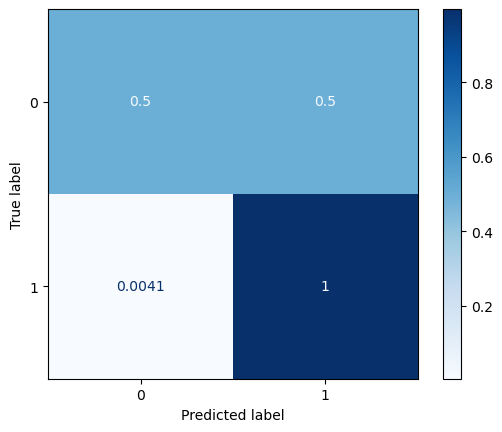

In [38]:
scores_df = get_accuracies(X_train_cv, y_train, X_test_cv, y_test, gs_bal.best_estimator_, 'bal_ros_logr', norm = 'true')

In [ ]:
scores_df = get_accuracies(X_train_cv, y_train, X_test_cv, y_test, logr, 'logr', scores_df, norm = 'true')

In [ ]:
pipe_mnb = Pipeline([
    ('ros', RandomOverSampler()),
    ('mnb', MultinomialNB())
])

In [ ]:
gs_mnb = GridSearchCV(
    pipe_mnb,
    param_grid={
        'ros__sampling_strategy' : [0.2, 0.35, 0.5,0.9, 1],
        'mnb__alpha' : [1, 2, 3, 5, 7, 8]
    }, cv = 5, verbose = 1, n_jobs=-1, scoring='balanced_accuracy'
)

In [ ]:
gs_mnb.fit(X_train_cv, y_train)

In [ ]:
gs_mnb.best_estimator_

In [ ]:
gs_mnb.best_params_

In [ ]:
scores_df = get_accuracies(X_train_cv, y_train, X_test_cv, y_test, gs_mnb.best_estimator_, 'bal_ros_mnb', scores_df, norm = 'true')

In [ ]:
pipe_rf = Pipeline([
    ('ros', RandomOverSampler()),
    ('rf', RandomForestClassifier())
])

In [ ]:
gs_rf = GridSearchCV(
    pipe_rf,
    param_grid = {
        'ros__sampling_strategy' :[0.5],
        'rf__max_depth' : [3,5,7],
        'rf__n_estimators' : [80, 100, 120]
    }, cv = 2, verbose = 1, n_jobs=-1, scoring='balanced_accuracy'
)

In [ ]:
gs_rf.fit(X_train_cv, y_train)

In [ ]:
scores_df = get_accuracies(X_train_cv, y_train, X_test_cv, y_test, gs_rf.best_estimator_, 'bal_ros_rf', scores_df, norm='true')

In [ ]:
pipe_bnb = Pipeline([
    ('ros', RandomOverSampler()),
    ('bnb', BernoulliNB())
])

In [ ]:
gs_bnb = GridSearchCV(
    pipe_bnb,
    param_grid={
        'ros__sampling_strategy' : [0.2, 0.35, 0.5,0.9],
        'bnb__alpha' : [0.1, 0.4, 0.6, 0.9, 1]
    }, cv = 5, verbose = 1, n_jobs=-1, scoring='balanced_accuracy'
)

In [ ]:
gs_bnb.fit(X_train_cv, y_train)

In [ ]:
gs_bnb.best_estimator_

In [ ]:
scores_df = get_accuracies(X_train_cv, y_train, X_test_cv, y_test, gs_bnb.best_estimator_, 'bal_ros_bnb', scores_df, norm= 'true')

In [ ]:
stack = [
    ('mnb' , gs_mnb.best_estimator_),
    ('bnb' , gs_bnb.best_estimator_),
    ('lr' , LogisticRegression(max_iter = 100_000)),
#     ('et', gs_et.best_estimator_)
    
]

In [ ]:
stx_mod = StackingClassifier(
    estimators=stack,
    final_estimator=gs_bal.best_estimator_
)

In [ ]:
stx_mod.fit(X_train_cv, y_train)

In [ ]:
scores_df = get_accuracies(X_train_cv, y_train, X_test_cv, y_test, stx_mod, 'stack', scores_df, norm='true')

In [ ]:
pipe_et = Pipeline([
    ('ros', RandomOverSampler()),
    ('et', ExtraTreesClassifier())
])

In [ ]:
gs_et = GridSearchCV(
    pipe_et,
    param_grid={
        'ros__sampling_strategy' : [0.9],
        'et__min_samples_split' : [3],
        'et__max_depth' : [5]
    }, cv = 3, verbose= 1, n_jobs=-1, scoring='balanced_accuracy'
)

In [ ]:
gs_et.fit(X_train_cv, y_train)

In [ ]:
gs_et.best_estimator_

In [ ]:
scores_df = get_accuracies(X_train_cv, y_train, X_test_cv, y_test, gs_et.best_estimator_, 'bal_ros_et', scores_df, norm='true')

In [ ]:
# %%timeit
# # set dictionary to house best estimators and params
# best_models = {}
# # for loop through the 3 1st level keys of model_model dict
# for key, value in model_dict.items():
#     # set pipeline with Count Vectorizer
#     pipe = Pipeline([('cvec', CountVectorizer())])
#     # append current model iteration tuple
#     pipe.steps.append(value['model'])
#     print(pipe)
#     gs = GridSearchCV(pipe, # set as iteration of pipe
#                   value['params'], # set as iteration of pipe_params
#                       cv=5, # Cross Validation of 5
#                       n_jobs=-1) # Unlock CPU to help process
#     # fit the current iteration of GridSearchCV
#     gs.fit(X_train, y_train)
#     # save the best model and best params 
#     best_models[key] = {'model': gs.best_estimator_, 'params': gs.best_params_}
#     print(best_models)